x_train shape: (120000, 28, 28, 1)
120000 train samples
20000 test samples
number of classes: 20
After augmentation:
x_train shape: (480000, 28, 28, 1)
480000 train samples
80000 test samples


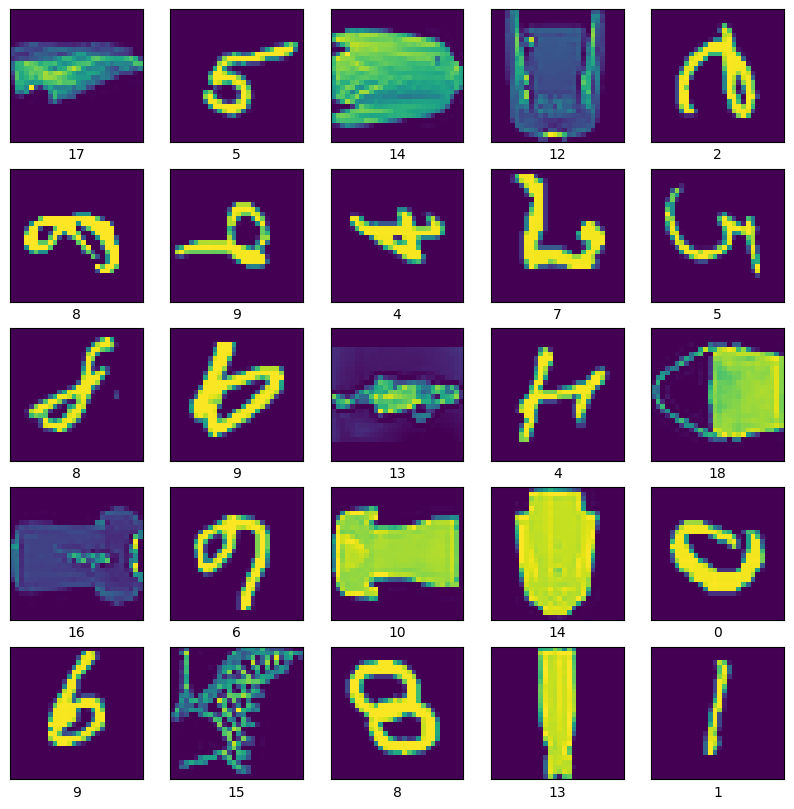

In [14]:
import numpy as np
import keras
import matplotlib.pyplot as plt

"""
0 0-9 digits
"""
#(x_handwritten_mnist_train, y_handwritten_mnist_train), (x_handwritten_mnist_test, y_handwritten_mnist_test) = keras.datasets.mnist.load_data()
handwritten_mnist = keras.datasets.mnist.load_data()
"""
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
"""
# (x_fashion_mnist_train, y_fashion_mnist_train), (x_fashion_mnist_test, y_fashion_mnist_test) = keras.datasets.fashion_mnist.load_data()
fashion_mnist = keras.datasets.fashion_mnist.load_data()

# combine the two datasets, changing the labels of the fashion MNIST +10 (num_handwritten_classes) to avoid overlap
num_handwritten_classes = len(np.unique(handwritten_mnist[0][1]))
x_mnist_train = np.concatenate((handwritten_mnist[0][0], fashion_mnist[0][0]), axis=0) # image: shape (60000, 28, 28)
y_mnist_train = np.concatenate((handwritten_mnist[0][1], fashion_mnist[0][1] + num_handwritten_classes), axis=0) # label: shape (60000,)
x_mnist_test = np.concatenate((handwritten_mnist[1][0], fashion_mnist[1][0]), axis=0) # image: shape (10000, 28, 28)
y_mnist_test = np.concatenate((handwritten_mnist[1][1], fashion_mnist[1][1] + num_handwritten_classes), axis=0) # label: shape (10000,)

# Scale images to the [0, 1] range
x_mnist_train = x_mnist_train.astype("float32") / 255
x_mnist_test = x_mnist_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_mnist_train = np.expand_dims(x_mnist_train, -1)
x_mnist_test = np.expand_dims(x_mnist_test, -1)
print("x_train shape:", x_mnist_train.shape)
print(x_mnist_train.shape[0], "train samples")
print(x_mnist_test.shape[0], "test samples")

# find number of classes
num_classes = len(np.unique(np.concatenate((y_mnist_train, y_mnist_test))))
print("number of classes:", num_classes)

# convert class vectors to binary class matrices
y_mnist_train = keras.utils.to_categorical(y_mnist_train, num_classes) 
y_mnist_test = keras.utils.to_categorical(y_mnist_test, num_classes)

# increase dataset size (not necessarily complexity) by rotating images by 90,180,270 degrees
def augment_data(x_data, y_data):
    x_augmented = []
    y_augmented = []
    for i in range(x_data.shape[0]):
        x_augmented.append(x_data[i])
        y_augmented.append(y_data[i])
        for angle in [90, 180, 270]:
            x_rotated = np.rot90(x_data[i], k=angle//90)
            x_augmented.append(x_rotated)
            y_augmented.append(y_data[i])
    return np.array(x_augmented), np.array(y_augmented)
x_mnist_train, y_mnist_train = augment_data(x_mnist_train, y_mnist_train)
x_mnist_test, y_mnist_test = augment_data(x_mnist_test, y_mnist_test)
print("After augmentation:")
print("x_train shape:", x_mnist_train.shape)
print(x_mnist_train.shape[0], "train samples")
print(x_mnist_test.shape[0], "test samples")

# shuffle the combined dataset
rng = np.random.default_rng(seed=42)
train_indices = rng.permutation(x_mnist_train.shape[0])
x_mnist_train = x_mnist_train[train_indices]
y_mnist_train = y_mnist_train[train_indices]
# same for test set
test_indices = rng.permutation(x_mnist_test.shape[0])
x_mnist_test = x_mnist_test[test_indices]
y_mnist_test = y_mnist_test[test_indices]

# show some data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_mnist_train[i].reshape(28,28)
               #, cmap=plt.cm.binary
               )
    plt.xlabel(np.argmax(y_mnist_train[i]))

In [15]:
import keras
import torch

teacher = keras.models.load_model('mnist-cnn-model.keras')

In [16]:
from keras import layers
# note: student model is smaller than teacher model (fewer parameters and lower computational cost)
num_classes = 20
input_shape = (28, 28, 1)
student = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu"), #16 vs 64
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu"), #16 vs 32
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5), 
        keras.layers.Dense(num_classes, activation="softmax"),
    ],name="mnist-cnn-student"
)

# clone student for later comparison
student_scratch = keras.models.clone_model(student)

teacher.summary()
student.summary()

Model: "mnist-cnn-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │        32,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,510 (595.75 KB)

 Trainable params: 50,836 (198.58 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 101,674 (397.17 KB)

Model: "mnist-cnn-student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         8,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,500 (41.02 KB)

 Trainable params: 10,500 (41.02 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from keras import ops

@keras.saving.register_keras_serializable()
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1, # 0.1 means 10% learning from ground-truth, 90% from teacher
        # low temperature (1) makes the softmax sharper [0.01, 0.01, 0.97, ...], high temperature (10) makes it softer (more spread out) [0.1, 0.2, 0.3, ...]
        temperature=10, # high temperature reveals more of the teacher's knowledge
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions. 
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
    # loss: numerical measure of how wrong the predictions are, it's a 'penality score' where lower is better predictions
    # during training, the model adjust its weights to minimize this loss, 'learning' to make better predictions
    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False) # here the teacher doesn't just say the right answer, it provides its full prediction distribution
        student_loss = self.student_loss_fn(y, y_pred) #cross-entropy loss between ground-truth and student predictions
        # Kullback-Leibler divergence loss between teacher and student predictions (complete distribution among classes): this is WHERE the knowledge distillation happens
        # the student doesn't just learn to predict the right class (doesn't copy the teacher pred!), it learns to mimic the teacher's full prediction distribution
        # if the student simply copied the teacher's predictions:
        #   1. it would not learn to generalize from the ground-truth labels (unseen images)
        #   2. not learn the underlying patterns (needs to develop its own 'understanding')
        #   3. the student has fewer parameters, so it cannot exactly replicate the teacher's behavior but approximates it adjustingly its own weights
        #instead the student learns the function, not the outputs
        distillation_loss = self.distillation_loss_fn(
            ops.softmax(teacher_pred / self.temperature, axis=1),
            ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2) # scales the loss to keep it balanced with the student loss
        # finally combine the two losses: the student improves both on ground-truth and on teacher predictions
        # student loss only: the image is labeled as "7", so the student should predict class 7 with high confidence
        # with distillation loss: the image is labeled as "7" with 90% confidence, but also class 2 and 9 with lower confidence, so the student should mimic this behavior
        # instead of forcing the student to be 100% certain, it learns the teacher's "wisdom" about uncertainty
        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss # 10% from ground-truth, 90% from distillation teacher
        return loss

    def call(self, x):
        return self.student(x)

In [18]:
# distill teacher to student
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer="adam",
    metrics=["accuracy"],
    student_loss_fn=keras.losses.CategoricalCrossentropy(), #cross-entropy loss between ground-truth and student predictions
    distillation_loss_fn=keras.losses.KLDivergence(), # KL divergence between teacher and student predictions
    alpha=0.1, # 0.1 means 10% learning from ground-truth, 90% from teacher
    temperature=10, #  # high temperature reveals more of the teacher's knowledge: low temperature (1) makes the softmax sharper [0.01, 0.01, 0.97, ...], high temperature (10) makes it softer (more spread out) [0.1, 0.2, 0.3, ...]
)
# train student through distillation
distiller.fit(x_mnist_train, y_mnist_train, epochs=3, verbose=1)
distiller.save('mnist-cnn-distilled.keras')
distiller.student.save('mnist-cnn-distilled-student.keras')

Epoch 1/3
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 135s 9ms/step - accuracy: 0.8072 - loss: 0.0593
Epoch 2/3
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 135s 9ms/step - accuracy: 0.8661 - loss: 0.0408
Epoch 3/3
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 140s 9ms/step - accuracy: 0.8776 - loss: 0.0373


In [10]:
# train student from scratch for comparison, as usually done
student_scratch.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
student_scratch.fit(x_mnist_train, y_mnist_train, epochs=3, verbose=1)
student_scratch.save('mnist-cnn-student.keras')

Epoch 1/3
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 69s 5ms/step - accuracy: 0.7036 - loss: 0.8733
Epoch 2/3
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.7628 - loss: 0.6917
Epoch 3/3
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - accuracy: 0.7741 - loss: 0.6581


In [19]:
teacher = keras.models.load_model('mnist-cnn-model.keras')      
distilled_student = keras.models.load_model('mnist-cnn-distilled-student.keras',compile=False)
# recompile distilled model
distilled = Distiller(student=distilled_student, teacher=teacher)
distilled.compile(
    optimizer="adam",
    metrics=["accuracy"],
    student_loss_fn=keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)
student_scratch = keras.models.load_model('mnist-cnn-student.keras')
# Evaluate student on test dataset
teacher.evaluate(x_mnist_test, y_mnist_test, verbose=2)
distilled.evaluate(x_mnist_test, y_mnist_test, verbose=2)
student_scratch.evaluate(x_mnist_test, y_mnist_test, verbose=2)

2500/2500 - 8s - 3ms/step - accuracy: 0.9137 - loss: 0.2519
2500/2500 - 10s - 4ms/step - accuracy: 0.8741 - loss: 0.0388
2500/2500 - 7s - 3ms/step - accuracy: 0.8492 - loss: 0.4476


[0.4476426839828491, 0.8492000102996826]

Teacher - Loss: 0.2519, Accuracy: 0.9137


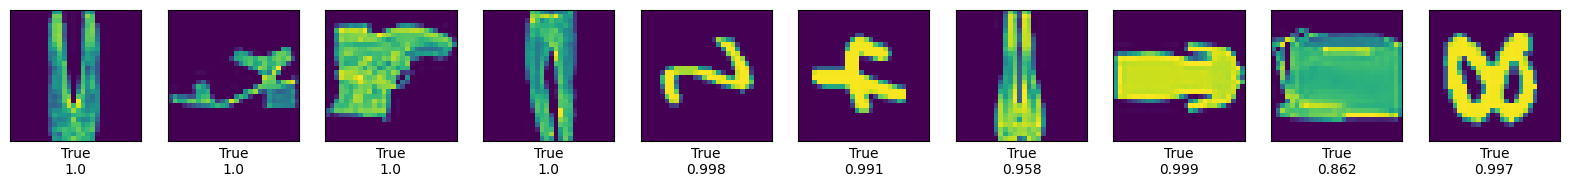

Distilled - Loss: 0.0388, Accuracy: 0.8741


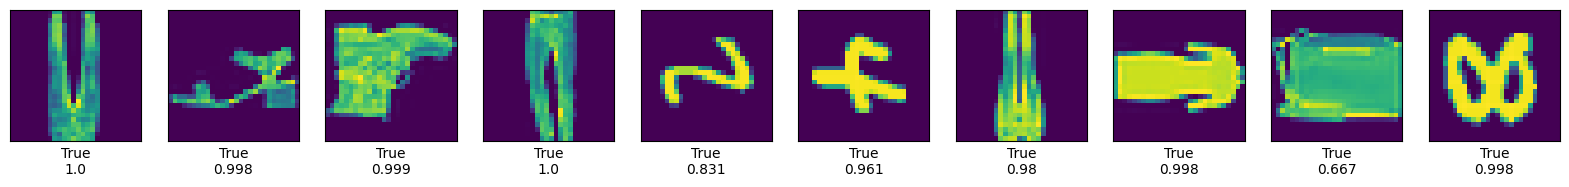

Student Scratch - Loss: 0.4476, Accuracy: 0.8492


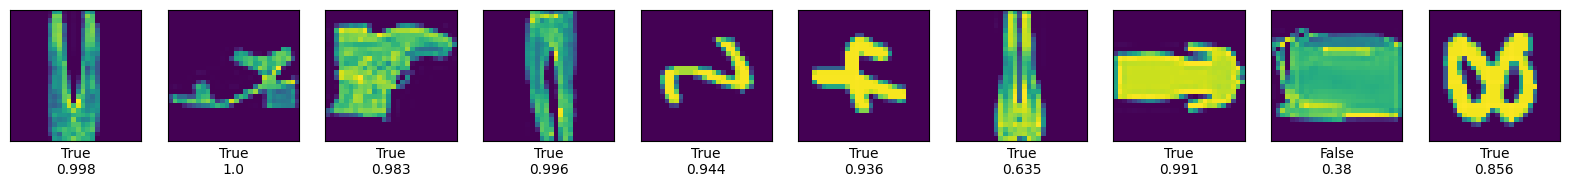

In [29]:
idx = range(10) #np.random.choice(x_mnist_test.shape[0], 10, replace=False)

def evaluate_model(q_model: keras.Model, model_name="Model"):
    score = q_model.evaluate(x_mnist_test, y_mnist_test, verbose=0)
    print(f"{model_name} - Loss: {score[0]:.4f}, Accuracy: {score[1]:.4f}")

    plt.figure(figsize=(20,30))    
    x_mnist_rnd, y_mnist_rnd = x_mnist_test[idx], y_mnist_test[idx]
    for i in range(10):    
        plt.subplot(1,10,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(
            x_mnist_rnd[i].reshape(28,28), 
            #cmap=plt.cm.binary
            )
        _preds = q_model.predict(x_mnist_rnd[i:i+1], verbose=0)[0]
        #print(f"Image {i} predictions: {_preds.round(3)}")
        plt.xlabel(f"{np.argmax(_preds)==np.argmax(y_mnist_rnd[i])}\n{np.max(_preds).round(3).astype(str)}")
    plt.show()

for model, name in zip(
    [teacher, distilled, student_scratch],
    ["Teacher", "Distilled", "Student Scratch"]
):
    evaluate_model(model, model_name=name)

In [ ]:
!pip install -U peft trl

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import Dataset
import os
import json

# Setup the Student (local model) 
model_base = "Qwen/Qwen3-0.6B"
model_id = os.path.join(os.environ['HF_HOME'], 'hub', f'models--{model_base.replace("/", "--")}-q8')

# Configure 4-bit quantization to save memory
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # Enable 4-bit quantization (reduces memory)
    bnb_4bit_quant_type="nf4", # NormalFloat4: optimized 4-bit format, preserving model quality better than naive 4bit "fp4"
    bnb_4bit_compute_dtype=torch.bfloat16 # Use bfloat16 for computations (faster on modern GPUs)
)

# Load the model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config, # Apply 4-bit quantization (model weights stored in 4-bit format => less memory)
    device_map="auto", # Automatically use the GPU if available
    trust_remote_code=True
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token # Set pad token

c:\Users\m.dipaolo\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\quantizers\auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


In [31]:
# This system prompt is the "new ability" we want to teach.
# It's very strict.
SYSTEM_PROMPT = """You are an expert text classifier. You MUST respond with ONLY a single, minified JSON object in the format: {"classification": "...", "tone": "...", "alert": "..." }.

Valid classifications are: BUG, FEATURE_REQUEST, INQUIRY
Valid tones are: POSITIVE, NEUTRAL, ANGRY
Valid alerts are: 😀, 😐, 😡

Alert must match the tone. Do not add any other text, explanations, or markdown formatting."""

def create_prompt_messages(ticket_text):
    """Helper function to format the chat prompt"""
    return [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": f"Analyze the following support ticket:\n\n{ticket_text}"}
    ]

# Helper function to run inference
def generate_response(model_to_test, test_messages):
    # Apply the chat template
    prompt = tokenizer.apply_chat_template(
        test_messages, 
        tokenize=False, 
        add_generation_prompt=True,
        enable_thinking=False
    )
    
    # Tokenize the input
    inputs = tokenizer(prompt, return_tensors="pt").to(model_to_test.device)
    
    # Generate the output
    outputs = model_to_test.generate(
        **inputs,
        max_new_tokens=200,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )
    
    # Decode the output, skipping special tokens and the prompt itself
    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return response.strip()

In [32]:
print("--- 🧪 Testing UNTRAINED Student Model ---")

test_ticket = "Your app crashed again! This is the third time. I can't even open my files! This is unacceptable."
test_messages = create_prompt_messages(test_ticket)

# Test the base model
base_model_response = generate_response(model, test_messages)

print(f"Ticket: {test_ticket}\n")
print(f"Response from base model:\n{base_model_response}")

# Check if it's valid JSON
try:
    rs = json.loads(base_model_response)
    print("✅ Valid JSON")
    try:
        assert rs["classification"] in ["BUG", "FEATURE_REQUEST", "INQUIRY"], print("🛑 invalid classification")
        assert rs["tone"] in ["POSITIVE", "NEUTRAL", "ANGRY"], print("🛑 invalid tone")
        assert rs["alert"] in ["😀", "😐", "😡"], print("🛑 invalid alert")
        assert rs["alert"] == ("😀" if rs["tone"] == "POSITIVE" else "😐" if rs["tone"] == "NEUTRAL" else "😡"), print("🛑 alert does not match tone")
        print("✅ SUCCESS. well done!")
    except AssertionError:
        print("🛑 FAILED. JSON fields have invalid values.")    
except json.JSONDecodeError:
    print("🛑 FAILED. Not valid JSON.")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


--- 🧪 Testing UNTRAINED Student Model ---
Ticket: Your app crashed again! This is the third time. I can't even open my files! This is unacceptable.

Response from base model:
{"classification": "BUG", "tone": "ANGER", "alert": "😀"}
✅ Valid JSON
🛑 invalid tone
🛑 FAILED. JSON fields have invalid values.


In [ ]:
from openai import OpenAI
client = OpenAI()

# A small dataset of raw prompts
raw_tickets = [
    "I love the new update! The interface is so clean.",
    "My password reset link isn't working. Can you help?",
    "This app is unusable! It just deleted all my data!",
    "It would be really cool if you could add a dark mode.",
    "I'm not sure how to find the settings menu.",
    "The new export feature is amazing, thank you!",
    "Why does it keep logging me out? It's so annoying.",
    "Requesting an integration with Google Calendar.",
    "Just writing to say thanks for this great tool!",
    "The billing page is confusing. Where's my last invoice?",
    "It's broken. The main dashboard won't load at all.",
    "I'd like to see a 'project templates' feature.",
    "Your support team is the best. Quick and helpful.",
    "The app is slow today. Is there an outage?",
    "THIS IS AWFUL. I'M SO MAD. FIX IT.",
    "Can you help me with my account issues?",
    "The app keeps crashing on startup.",
    "I'm getting a 500 error when I try to upload files.",
    "The new analytics dashboard is not loading.",
    "Can you assist me with a bug in the app?",
    "I'm having trouble with the API integration.",
    "THIS IS UNACCEPTABLE! I DEMAND A FIX NOW!",
    "I CAN'T TAKE THIS ANYMORE! FIX IT NOW!",
]

def get_teacher_response(ticket_text):
    """Calls the OpenAI API to get a perfect response."""
    messages = create_prompt_messages(ticket_text)
    
    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini", # Teacher model
            messages=messages,
            temperature=0,
            max_tokens=50
        )
        return completion.choices[0].message.content
    except Exception as e:
        print(f"Error calling OpenAI: {e}")
        return None

# --- Create the dataset ---
distilled_data = []
print("--- 🤖 Calling Teacher API to generate dataset ---")

for ticket in raw_tickets:
    # 1. Get the "perfect" JSON response from the teacher
    teacher_response = get_teacher_response(ticket)
    
    if teacher_response:
        print(f"Ticket: {ticket[:30]}... -> Response: {teacher_response}")
        
        # 2. Format it as a "messages" list
        distilled_data.append({
            "messages": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": f"Analyze the following support ticket:\n\n{ticket}"},
                {"role": "assistant", "content": teacher_response} # This is the "label"
            ]
        })

print(f"\n--- ✅ Dataset creation complete. Total examples: {len(distilled_data)} ---")

# Convert to Hugging Face Dataset object
hf_dataset = Dataset.from_list(distilled_data)
hf_dataset.save_to_disk("./tmp/hf_distilled_dataset")
import pandas as pd
df = pd.DataFrame(hf_dataset)   
df.to_json("./tmp/distilled_dataset.json")
df.to_csv("./tmp/distilled_dataset.csv")

--- 🤖 Calling Teacher API to generate dataset ---
Ticket: I love the new update! The int... -> Response: {"classification":"FEATURE_REQUEST","tone":"POSITIVE","alert":"😀"}
Ticket: My password reset link isn't w... -> Response: {"classification":"INQUIRY","tone":"NEUTRAL","alert":"😐"}
Ticket: This app is unusable! It just ... -> Response: {"classification":"BUG","tone":"ANGRY","alert":"😡"}
Ticket: It would be really cool if you... -> Response: {"classification":"FEATURE_REQUEST","tone":"POSITIVE","alert":"😀"}
Ticket: I'm not sure how to find the s... -> Response: {"classification":"INQUIRY","tone":"NEUTRAL","alert":"😐"}
Ticket: The new export feature is amaz... -> Response: {"classification":"FEATURE_REQUEST","tone":"POSITIVE","alert":"😀"}
Ticket: Why does it keep logging me ou... -> Response: {"classification":"BUG","tone":"ANGRY","alert":"😡"}
Ticket: Requesting an integration with... -> Response: {"classification":"FEATURE_REQUEST","tone":"POSITIVE","alert":"😀"}
Ticket: Just writing t

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

16344

In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Prepares quantized models for training. Original weights are frozen, only LoRA adapters are ADDED and trainable
model = prepare_model_for_kbit_training(model) # Prepare model for LoRA fine-tuning (essential for quantized models)

lora_config = LoraConfig(
    r=16, # Rank/bottleneck dimension (controls capacity vs efficiency tradeoff), higher = more parameters, more capacity (e.g. for complex reasoning tasks), lower = less parameters, more efficient
    lora_alpha=32, # Scaling factor for LoRA weights (high = more influence on the model's behavior), typically 2×r
    # target_modules: which layers/modules to apply LoRA adapters to
    target_modules=[
        "q_proj",      # Query projection in multi-head attention: transforms input to query vectors
        "k_proj",      # Key projection in multi-head attention: transforms input to key vectors
        "v_proj",      # Value projection in multi-head attention: transforms input to value vectors
        "o_proj",      # Output projection after attention: combines attention outputs
        "gate_proj",   # Gating mechanism in feed-forward network (SwiGLU activation)
        "up_proj",     # First layer of FFN, expands dimension (up)
        "down_proj"    # Second layer of FFN, reduces dimension back (down)
    ], 
    lora_dropout=0.05, # regularization to prevent overfitting on small datasets, e.g 5% of LoRA neurons are randomly dropped during training
    bias="none", # dont train bias parameters (most parameter-efficient)
    task_type="CAUSAL_LM" #  Specifies autoregressive language modeling (for decoder-only models)
)

# Apply LoRA adapters to the model
# results in a model where original weights are frozen, and LoRA adapters are ADDED and trainable
# base model weights is in 4-bit quantized format, LoRA adapters are in full precision (float16)
model = get_peft_model(model, lora_config) #LoRa on top of quantized weights = QLoRa (Q4 + LoRa)

print("--- 📈 Model prepared for LoRA fine-tuning ---")
# Print trainable parameters to verify only LoRA adapters are trainable (and will be ADDED to the model)
model.print_trainable_parameters()
# NOTE: this new trainable parameters are FIXED, they do not depend on the dataset size. 
# LoRA parameter count is determined by MODEL ARCHITECTURE, not dataset size
# For each target module in each layer:
# Parameters = (input_dim + output_dim) × r
# Example with Qwen 3-0.6B:
# - 24 layers
# - 7 target modules per layer  
# - Various dimensions (768, 3072, etc.)
# Subsequent training on new tasks will only update these LoRA parameters, preserving the knowledge acquired in previous trainings (and the base model weights remain frozen)

--- 📈 Model prepared for LoRA fine-tuning ---
trainable params: 10,092,544 || all params: 606,142,464 || trainable%: 1.6650


- LoRa (Low-Rank Adaptation) is a technique used to fine-tune large language models (LLMs) efficiently by updating only a small number of parameters, rather than the entire model. This approach significantly reduces the computational resources and time required for training.
![LoRa](https://media.licdn.com/dms/image/v2/D5612AQHfM42NWm0L3Q/article-cover_image-shrink_600_2000/article-cover_image-shrink_600_2000/0/1729439416136?e=2147483647&v=beta&t=5qVvcfaGBVCa6Fzg9OMxerBvuXqNnJbE_K86ZAz1q4Q)
- QLoRa (Quantized Low-Rank Adaptation) is an extension of LoRa that combines low-rank adaptation with model quantization techniques. QLoRa further reduces the memory footprint and computational requirements by quantizing the model weights, allowing for even more efficient fine-tuning of large language models.
![LoRa vs QLoRa](https://cdn.prod.website-files.com/62528d398a42420e66390ef9/65fc1abec64c8a1acc9a21c3_image%20(1).png)

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

hf_dataset = Dataset.load_from_disk("./tmp/hf_distilled_dataset")

# Define Training Arguments
training_args = TrainingArguments(
    output_dir=os.path.join(os.environ['HF_HOME'], 'tmp', f"{model_id}-distilled"),
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    logging_steps=10,
    max_steps=hf_dataset.num_rows // 2,
    eval_strategy="no",
    num_train_epochs=2,
    push_to_hub=False,
)

# Create the SFTTrainer
trainer = SFTTrainer(
    model=model,
    train_dataset=hf_dataset,
    peft_config=lora_config,
    args=training_args
)

print("--- 🏁 Starting training... ---")
# Start training
trainer.train()
print("--- 🎉 Training complete! ---")

--- 🏁 Starting training... ---


c:\Users\m.dipaolo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\m.dipaolo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,1.624800


--- 🎉 Training complete! ---


In [74]:
trainer.save_model(os.path.join(os.environ['HF_HOME'], 'hub', f"{model_id}-distilled-final"))
model.save_pretrained(os.path.join(os.environ['HF_HOME'], 'hub', f"{model_id}-distilled-final"))


In [5]:
from transformers import AutoModelForCausalLM
from peft import PeftModel
import torch
import pandas as pd
from collections import defaultdict
import os

print("="*80)
print("🔍 INSPECTING LoRA ADAPTERS")
print("="*80)

# Load the model with LoRA adapters
model_path = 'models--Qwen--Qwen3-0.6B-q8'
lora_model_path = os.path.join(os.environ['HF_HOME'], 'hub', f"{model_path}-distilled-final")

# Load model with LoRA adapters
lora_model = AutoModelForCausalLM.from_pretrained(
    lora_model_path,
    device_map="auto",
    trust_remote_code=True
)

print("\n📊 LoRA Configuration:")
print("-" * 80)
if hasattr(lora_model, 'peft_config'):
    for key, config in lora_model.peft_config.items():
        print(f"\nAdapter: {key}")
        print(f"  Rank (r): {config.r}")
        print(f"  Alpha: {config.lora_alpha}")
        print(f"  Dropout: {config.lora_dropout}")
        print(f"  Target modules: {config.target_modules}")
        print(f"  Task type: {config.task_type}")

# Get all LoRA parameters
def extract_lora_params(model):
    """Extract all LoRA adapter parameters"""
    lora_params = {}
    
    for name, param in model.named_parameters():
        if 'lora' in name.lower():
            lora_params[name] = {
                'shape': tuple(param.shape),
                'num_params': param.numel(),
                'mean': param.data.float().mean().item(),
                'std': param.data.float().std().item(),
                'min': param.data.float().min().item(),
                'max': param.data.float().max().item(),
                'norm': torch.norm(param.data.float()).item(),
                'data': param.data.cpu().float()
            }
    
    return lora_params

print("\n" + "="*80)
print("📦 EXTRACTING LoRA PARAMETERS")
print("="*80)

lora_params = extract_lora_params(lora_model)

print(f"\n✓ Found {len(lora_params)} LoRA parameter tensors")
print(f"✓ Total LoRA parameters: {sum(p['num_params'] for p in lora_params.values()):,}")

# Create detailed DataFrame
lora_data = []
for name, stats in lora_params.items():
    # Parse layer info
    parts = name.split('.')
    layer_num = None
    module_type = None
    lora_type = None
    
    for i, part in enumerate(parts):
        if part.isdigit():
            layer_num = int(part)
        if 'lora_A' in part or 'lora_B' in part:
            lora_type = part
        if any(m in part for m in ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']):
            module_type = part
    
    lora_data.append({
        'name': name,
        'layer_num': layer_num,
        'module_type': module_type,
        'lora_type': lora_type,
        'shape': str(stats['shape']),
        'num_params': stats['num_params'],
        'mean': stats['mean'],
        'std': stats['std'],
        'min': stats['min'],
        'max': stats['max'],
        'norm': stats['norm']
    })

df_lora = pd.DataFrame(lora_data)

print("\n" + "="*80)
print("📈 LoRA STATISTICS BY MODULE TYPE")
print("="*80)

module_stats = df_lora.groupby('module_type').agg({
    'num_params': ['sum', 'count'],
    'norm': ['mean', 'std', 'min', 'max'],
    'std': 'mean'
}).round(4)

print(module_stats)

# Detailed layer inspection with shapes

def inspect_model_layers(model, show_details=True):
    """Inspect all model layers with their shapes and parameter counts"""
    
    print("\n" + "="*100)
    print("📊 LAYER-BY-LAYER ANALYSIS")
    print("="*100)
    
    total_params = 0
    layer_info = []
    
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Leaf modules only
            param_count = sum(p.numel() for p in module.parameters())
            if param_count > 0:
                # Get shapes of all parameters in this module
                param_shapes = []
                for param_name, param in module.named_parameters():
                    param_shapes.append(f"{param_name}: {tuple(param.shape)}")
                
                layer_info.append({
                    'name': name,
                    'type': type(module).__name__,
                    'param_count': param_count,
                    'param_shapes': param_shapes
                })
                total_params += param_count
                
                if show_details:
                    print(f"\n🔹 {name}")
                    print(f"   Type: {type(module).__name__}")
                    print(f"   Parameters: {param_count:,}")
                    for shape_info in param_shapes:
                        print(f"   Shape: {shape_info}")
    
    print(f"\n📈 Summary:")
    print(f"   Total layers with parameters: {len(layer_info)}")
    print(f"   Total parameters: {total_params:,}")
    
    return layer_info

# Inspect the model
layer_details = inspect_model_layers(lora_model, show_details=True)

def create_model_summary(model, target_modules):
    """Create a comprehensive summary DataFrame"""
    
    summary_data = []
    
    # Get basic model info
    config = model.config
    
    # Analyze each transformer layer
    for i, layer in enumerate(model.model.layers):
        layer_data = {
            'layer_idx': i,
            'layer_type': 'transformer'
        }
        
        # Attention projections
        if hasattr(layer, 'self_attn'):
            attn = layer.self_attn
            for proj_name in ['q_proj', 'k_proj', 'v_proj', 'o_proj']:
                if hasattr(attn, proj_name):
                    proj = getattr(attn, proj_name)
                    summary_data.append({
                        **layer_data,
                        'module_name': proj_name,
                        'full_path': f'model.layers.{i}.self_attn.{proj_name}',
                        'weight_shape': str(tuple(proj.weight.shape)),
                        'param_count': proj.weight.numel(),
                        'is_lora_target': proj_name in target_modules,
                        'input_dim': proj.weight.shape[1],
                        'output_dim': proj.weight.shape[0]
                    })
        
        # MLP projections
        if hasattr(layer, 'mlp'):
            mlp = layer.mlp
            for proj_name in ['gate_proj', 'up_proj', 'down_proj']:
                if hasattr(mlp, proj_name):
                    proj = getattr(mlp, proj_name)
                    summary_data.append({
                        **layer_data,
                        'module_name': proj_name,
                        'full_path': f'model.layers.{i}.mlp.{proj_name}',
                        'weight_shape': str(tuple(proj.weight.shape)),
                        'param_count': proj.weight.numel(),
                        'is_lora_target': proj_name in target_modules,
                        'input_dim': proj.weight.shape[1],
                        'output_dim': proj.weight.shape[0]
                    })
    
    df = pd.DataFrame(summary_data)
    
    print("\n" + "="*100)
    print("📋 MODEL SUMMARY TABLE")
    print("="*100)
    
    # Display summary
    print(f"\nTotal transformer layers: {len(model.model.layers)}")
    print(f"LoRA target modules: {target_modules}")
    
    # Group by module type
    module_summary = df.groupby(['module_name', 'is_lora_target']).agg({
        'param_count': ['count', 'sum'],
        'input_dim': 'first',
        'output_dim': 'first'
    }).round(0)
    
    print("\n📊 Module Type Summary:")
    print(module_summary)
    
    # LoRA parameter calculation
    lora_targets = df[df['is_lora_target'] == True]
    print(f"\n🎯 LoRA Target Analysis:")
    print(f"   Total LoRA target modules: {len(lora_targets)}")
    
    # Calculate LoRA parameters (assuming r=16)
    r = 16
    total_lora_params = 0
    for _, row in lora_targets.iterrows():
        lora_params = (row['input_dim'] + row['output_dim']) * r
        total_lora_params += lora_params
    
    print(f"   Estimated LoRA parameters (r={r}): {total_lora_params:,}")
    
    return df

# Create comprehensive summary
summary_df = create_model_summary(lora_model, target_modules= ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"])
print(summary_df.to_string())

   

🔍 INSPECTING LoRA ADAPTERS


Some parameters are on the meta device because they were offloaded to the cpu.



📊 LoRA Configuration:
--------------------------------------------------------------------------------

Adapter: default
  Rank (r): 16
  Alpha: 32
  Dropout: 0.05
  Target modules: {'o_proj', 'k_proj', 'gate_proj', 'q_proj', 'v_proj', 'up_proj', 'down_proj'}
  Task type: CAUSAL_LM

📦 EXTRACTING LoRA PARAMETERS

✓ Found 392 LoRA parameter tensors
✓ Total LoRA parameters: 10,092,544

📈 LoRA STATISTICS BY MODULE TYPE
            num_params          norm                             std
                   sum count    mean     std     min     max    mean
module_type                                                         
down_proj      1835008    56  1.2065  1.1242  0.0766  2.3315  0.0056
gate_proj      1835008    56  1.2381  1.0883  0.1374  2.3321  0.0094
k_proj          917504    56  1.2009  1.1239  0.0720  2.3252  0.0094
o_proj         1376256    56  1.2054  1.1248  0.0763  2.3310  0.0068
q_proj         1376256    56  1.2173  1.1025  0.1014  2.3241  0.0094
up_proj        1835008    56

In [33]:
import unicodedata

def normalize_string(s):
    """Remove invisible characters and normalize Unicode"""
    # Normalize and decompose
    s = unicodedata.normalize('NFD', s)
    # Keep only printable ASCII letters, numbers, and spaces
    s = ''.join(char for char in s if unicodedata.category(char) not in ['Mn', 'Cf', 'Cc', 'Cs', 'Co'])
    # Recompose
    s = unicodedata.normalize('NFC', s)
    return s.strip()

print("--- 🧪 Testing TRAINED Student Model ---")

# distilled model with LoRA adapters
tuned_model = AutoModelForCausalLM.from_pretrained(
    os.path.join(os.environ['HF_HOME'], 'hub', f"{model_id}-distilled-final"),
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

tickets = [{"The app is fantastic! I love using it every day."},
           {"I'm having trouble logging in. Please assist."},
           {"The new update is great, but I found a bug."},
           {"Can you help me with my account issues?"},
           {"THIS IS UNACCEPTABLE! I DEMAND A FIX NOW!"}]

for idx, ticket_text in enumerate(tickets):
    prompt_messages = create_prompt_messages(list(ticket_text)[0])
    tuned_model_response = generate_response(tuned_model, prompt_messages)
    result = f"{str(list(ticket_text)[0])[:100]}... -> {tuned_model_response}"
    try:
        rs = json.loads(tuned_model_response)
        if normalize_string(rs["classification"]) not in ["BUG", "FEATURE_REQUEST", "INQUIRY"]:
            result += " 🛑 invalid classification"
        if normalize_string(rs["tone"]) not in ["POSITIVE", "NEUTRAL", "ANGRY"]:
            result += " 🛑 invalid tone"
        if normalize_string(rs["alert"]) not in ["😀", "😐", "😡"]:
            result += " 🛑 invalid alert"
        if normalize_string(rs["alert"]) != ("😀" if normalize_string(rs["tone"]) == "POSITIVE" else "😐" if normalize_string(rs["tone"]) == "NEUTRAL" else "😡"):
            result += " 🛑 alert does not match tone"
        if (
            normalize_string(rs["classification"]) in ["BUG", "FEATURE_REQUEST", "INQUIRY"]
            and normalize_string(rs["tone"]) in ["POSITIVE", "NEUTRAL", "ANGRY"]
            and normalize_string(rs["alert"]) in ["😀", "😐", "😡"]
            and normalize_string(rs["alert"]) == ("😀" if normalize_string(rs["tone"]) == "POSITIVE" else "😐" if normalize_string(rs["tone"]) == "NEUTRAL" else "😡")
        ):
            result += " ✅ SUCCESS. well done!"
        else:
            result += " 🛑 FAILED. JSON fields have invalid values."
    except json.JSONDecodeError:
        result += " 🛑 FAILED. Not valid JSON."
    print(result)

--- 🧪 Testing TRAINED Student Model ---


Some parameters are on the meta device because they were offloaded to the cpu.


The app is fantastic! I love using it every day.... -> {"classification":"FEATURE_REQUEST️","tone":"POSITIVE","alert":"😀"} ✅ SUCCESS. well done!
I'm having trouble logging in. Please assist.... -> {"classification":"BUG","tone":"NEUTRAL","alert":"😐"} ✅ SUCCESS. well done!
The new update is great, but I found a bug.... -> {"classification":"BUG","tone":"POSITIVE","alert":"😀"} ✅ SUCCESS. well done!
Can you help me with my account issues?... -> {"classification":"INQUIRY","tone":"NEUTRAL","alert":"😐"} ✅ SUCCESS. well done!
THIS IS UNACCEPTABLE! I DEMAND A FIX NOW!... -> {"classification":"BUG","tone":"ANGRY","alert":"😡"} ✅ SUCCESS. well done!


In [8]:
query = "Write an haiku on LLM distillation"
print("--- Response from untrained model ---")
messages = [
        {"role": "user", "content": query}
    ]
response = generate_response(model, messages)
print(response)

print("\n\n--- Response from trained model ---")
messages = [
        {"role": "user", "content": query}
    ]
response = generate_response(tuned_model, messages)
print(response)

--- Response from untrained model ---
LLM distillation —  
A whisper of knowledge,  
A shadow of wisdom.


--- Response from trained model ---
Llama's wisdom streams,  
A whisper through data's haze.


In [37]:
# Test prompts to reveal emergent behaviors from distillation training
test_prompts = [    
    #  Related but broader analytical task
    "What is the customer sentiment about the app? 'The app keeps crashing!'",
    
    # Implicit tone detection (no explicit anger markers)
    "What's the sentiment here: 'I've been waiting for support for 3 days now.'",

    # Tests emoji understanding (learned from alert field)
    "What emoji best represents this message: 'This is unacceptable!' Choose: 😀 😐 😡",

    # Classification without explicit request
    "A customer wrote: 'Can you add a dark mode?' What kind of ticket request is this?",
]

print("--- 🧪 Comparing Base vs Trained Model on Emergent Skills ---\n")

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n{'='*80}")
    print(f"Test {i}: {prompt}")
    print('='*80)
    
    messages = [{"role": "user", "content": prompt}]
    
    print("\n📘 Base Model Response:")
    base_response = generate_response(model, messages)
    print(base_response)
    
    print("\n📗 Trained Model Response:")
    trained_response = generate_response(tuned_model, messages)
    print(trained_response)
    
    print("\n" + "-"*80)

--- 🧪 Comparing Base vs Trained Model on Emergent Skills ---


Test 1: What is the customer sentiment about the app? 'The app keeps crashing!'

📘 Base Model Response:
The customer sentiment about the app is that it "keeps crashing."

📗 Trained Model Response:
The sentiment expressed by the customer is **negative**.

--------------------------------------------------------------------------------

Test 2: What's the sentiment here: 'I've been waiting for support for 3 days now.'

📘 Base Model Response:
The sentiment here is **positive**. The phrase "I've been waiting for support for 3 days now" suggests that the speaker is currently in need of assistance and is actively seeking it. The duration of waiting (3 days) adds to the urgency, which reinforces a positive tone.

📗 Trained Model Response:
The sentiment here is **negative**.

--------------------------------------------------------------------------------

Test 3: What emoji best represents this message: 'This is unacceptable!' Cho